## COMPSCI 675 Introduction to Deep Learning
## **Project 5**
### December 3rd, 2025

#### **Purpose:** The following notebook evaluates the PropensityNet architecture on the real-synthetic dataset.

In [1]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss
import zipfile
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/archive.zip"  # adjust path
data_dir = "Data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)
print("Data extracted from Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data extracted from Drive!


### **Real+Synthetic Dataset**

In [5]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, in_channels=1, output_dim=256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [6]:
class MedicalImageDataset(Dataset):
    """
    Load real medical images from Data/train or Data/test
    Generate only missing confounders U and treatment assignments
    Use actual disease category to define outcomes
    """
    def __init__(self, data_dir, split='train', image_size=64,
                 confounder_dim=8, beta_strength=1.0):
        self.data_dir = Path(data_dir) / split
        self.image_size = image_size
        self.confounder_dim = confounder_dim
        self.beta_strength = beta_strength

        self.image_paths = []
        self.categories = []

        for category in ['NORMAL', 'PNEUMONIA', 'COVID19']:
            category_path = self.data_dir / category
            if category_path.exists():
                for img_path in sorted(category_path.glob('*.jpg')):
                    self.image_paths.append(img_path)
                    self.categories.append(category)

        print(f"\nLoaded {len(self.image_paths)} images from {split} split")
        category_counts = pd.Series(self.categories).value_counts()
        print(f"Categories: {category_counts.to_dict()}")

        self._generate_confounders_and_treatment()

    def _load_image(self, img_path):
        """Load and preprocess a single image"""
        img = Image.open(img_path).convert('L')  # Grayscale
        img = img.resize((self.image_size, self.image_size))
        img = np.array(img, dtype=np.float32) / 255.0
        img = (img - 0.5) / 0.5  # Normalize to [-1, 1]
        return torch.FloatTensor(img).unsqueeze(0)

    def _generate_confounders_and_treatment(self):
        """
        Generate missing confounders U and treatment assignments.
        U represents unmeasured patient characteristics (comorbidities, genetics, etc.)
        Treatment assignment depends on both observed images and unobserved U.
        """
        n = len(self.image_paths)

        Z2 = np.random.randn(n, self.confounder_dim)

        self.U = Z2 + np.random.randn(n, self.confounder_dim) * 0.1

        # Map disease categories to severity scores (for treatment propensity)?????
        severity_map = {'NORMAL': 0.0, 'PNEUMONIA': 0.5, 'COVID19': 1.0}
        severity = np.array([severity_map[cat] for cat in self.categories])

        print("Generate treatment assignments:")
        # Treatment propensity based on:
        # - Disease severity (observable from images)
        # - Confounders U (unobservable patient characteristics)
        alpha = 2.0  # Weight for disease severity
        beta = np.random.randn(self.confounder_dim)
        beta = beta / np.linalg.norm(beta) * self.beta_strength

        logits = alpha * severity + self.U @ beta
        propensity = 1 / (1 + np.exp(-logits))
        self.T = (np.random.rand(n) < propensity).astype(np.int64)

        print(f"Treatment rate: {self.T.mean():.3f}")
        print(f"Treatment by category:")
        for cat in ['NORMAL', 'PNEUMONIA', 'COVID19']:
            mask = np.array(self.categories) == cat
            if mask.sum() > 0:
                print(f"  {cat}: {self.T[mask].mean():.3f}")

        base_outcome = severity * 5.0 + self.U[:, 0] * 1.0 + np.random.randn(n) * 0.5

        # Treatment effect: more effective for severe cases
        treatment_effect = -(2.0 + severity * 3.0 + self.U[:, 1] * 0.5)

        # Potential outcomes
        self.Y0 = base_outcome + np.random.randn(n) * 0.3  # Without treatment
        self.Y1 = base_outcome + treatment_effect + np.random.randn(n) * 0.3  # With treatment

        # Observed outcome (factual)
        self.Y = self.T * self.Y1 + (1 - self.T) * self.Y0

        # True individual treatment effect
        self.true_ITE = self.Y1 - self.Y0

        print(f"Outcome statistics:")
        print(f"  Y0 (control): mean={self.Y0.mean():.3f}, std={self.Y0.std():.3f}")
        print(f"  Y1 (treated): mean={self.Y1.mean():.3f}, std={self.Y1.std():.3f}")
        print(f"  True ATE: {self.true_ITE.mean():.3f}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = self._load_image(self.image_paths[idx])
        return {
            'image': img,
            'treatment': torch.LongTensor([self.T[idx]])[0],
            'outcome': torch.FloatTensor([self.Y[idx]])[0],
            'y0': torch.FloatTensor([self.Y0[idx]])[0],
            'y1': torch.FloatTensor([self.Y1[idx]])[0],
            'ite': torch.FloatTensor([self.true_ITE[idx]])[0],
            'category': self.categories[idx]
        }

In [9]:
# Data Setup
data_dir = "Data/Data"
image_size = 64
confounder_dim = 8  # Dimension of unobserved confounders U
beta_strength = 1.0  # Strength of confounding (higher = more bias)

train_dataset = MedicalImageDataset(
    data_dir=data_dir,
    split='train',
    image_size=image_size,
    confounder_dim=confounder_dim,
    beta_strength=beta_strength
)

test_dataset = MedicalImageDataset(
    data_dir=data_dir,
    split='test',
    image_size=image_size,
    confounder_dim=confounder_dim,
    beta_strength=beta_strength
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created with batch_size={batch_size}")


Loaded 5144 images from train split
Categories: {'PNEUMONIA': 3418, 'NORMAL': 1266, 'COVID19': 460}
Generate treatment assignments:
Treatment rate: 0.663
Treatment by category:
  NORMAL: 0.499
  PNEUMONIA: 0.701
  COVID19: 0.837
Outcome statistics:
  Y0 (control): mean=2.100, std=1.804
  Y1 (treated): mean=-1.166, std=1.382
  True ATE: -3.265

Loaded 1288 images from test split
Categories: {'PNEUMONIA': 855, 'NORMAL': 317, 'COVID19': 116}
Generate treatment assignments:
Treatment rate: 0.662
Treatment by category:
  NORMAL: 0.479
  PNEUMONIA: 0.702
  COVID19: 0.871
Outcome statistics:
  Y0 (control): mean=2.097, std=1.810
  Y1 (treated): mean=-1.184, std=1.368
  True ATE: -3.281

DataLoaders created with batch_size=32


### **Propensity Net Evaluation**

We first load the propensitynet class

In [10]:
class PropensityNet(nn.Module):
    """Predict e(x) = P(T=1|X) using the same CNN backbone."""
    def __init__(self, in_channels=1, rep_dim=256):
        super().__init__()
        self.cnn_feat = CNNFeatureExtractor(in_channels=in_channels, output_dim=rep_dim)
        self.mlp = nn.Sequential(
            nn.Linear(rep_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        rep = self.cnn_feat(x)
        logits = self.mlp(rep).squeeze(-1)
        return torch.sigmoid(logits)

Next, we define a function to train on the semi-synthetic dataset:

In [11]:
def train_propensity(prop_model, train_loader, num_epochs=20, lr=1e-3):
    prop_model.train()
    optim_p = optim.Adam(prop_model.parameters(), lr=lr, weight_decay=1e-4)
    bce = nn.BCELoss()
    losses = []

    for epoch in range(num_epochs):
        total = 0
        for batch in train_loader:
            x = batch['image'].to(device)
            t = batch['treatment'].float().to(device)

            optim_p.zero_grad()
            p_hat = prop_model(x)
            loss = bce(p_hat, t)
            loss.backward()
            optim_p.step()
            total += loss.item()

        losses.append(total / len(train_loader))
        print(f"[Propensity] Epoch {epoch+1}/{num_epochs} - Loss {losses[-1]:.4f}")

    return losses


Finally, to evaluate the model we have the following function:

In [12]:
def evaluate_propensity(prop_model, test_loader):
    prop_model.eval()

    all_p = []
    all_t = []

    with torch.no_grad():
        for batch in test_loader:
            x = batch['image'].to(device)
            t = batch['treatment'].float().cpu().numpy()

            p_hat = prop_model(x).cpu().numpy()

            all_p.append(p_hat)
            all_t.append(t)

    all_p = np.concatenate(all_p)
    all_t = np.concatenate(all_t)

    auc = roc_auc_score(all_t, all_p)
    acc = accuracy_score(all_t, (all_p > 0.5).astype(int))
    brier = brier_score_loss(all_t, all_p)

    print("\n===== Propensity Model Evaluation on REAL Data =====")
    print(f"AUC:          {auc:.4f}")
    print(f"Accuracy:     {acc:.4f}")
    print(f"Brier Score:  {brier:.4f}")
    print("===================================================\n")

    return all_p, all_t


===== Training Propensity Model =====
[Propensity] Epoch 1/20 - Loss 0.6479
[Propensity] Epoch 2/20 - Loss 0.6421
[Propensity] Epoch 3/20 - Loss 0.6406
[Propensity] Epoch 4/20 - Loss 0.6405
[Propensity] Epoch 5/20 - Loss 0.6397
[Propensity] Epoch 6/20 - Loss 0.6388
[Propensity] Epoch 7/20 - Loss 0.6392
[Propensity] Epoch 8/20 - Loss 0.6386
[Propensity] Epoch 9/20 - Loss 0.6363
[Propensity] Epoch 10/20 - Loss 0.6330
[Propensity] Epoch 11/20 - Loss 0.6333
[Propensity] Epoch 12/20 - Loss 0.6315
[Propensity] Epoch 13/20 - Loss 0.6308
[Propensity] Epoch 14/20 - Loss 0.6322
[Propensity] Epoch 15/20 - Loss 0.6310
[Propensity] Epoch 16/20 - Loss 0.6300
[Propensity] Epoch 17/20 - Loss 0.6330
[Propensity] Epoch 18/20 - Loss 0.6307
[Propensity] Epoch 19/20 - Loss 0.6293
[Propensity] Epoch 20/20 - Loss 0.6302

===== Evaluating Propensity Model =====

===== Propensity Model Evaluation on REAL Data =====
AUC:          0.6006
Accuracy:     0.6623
Brier Score:  0.2217



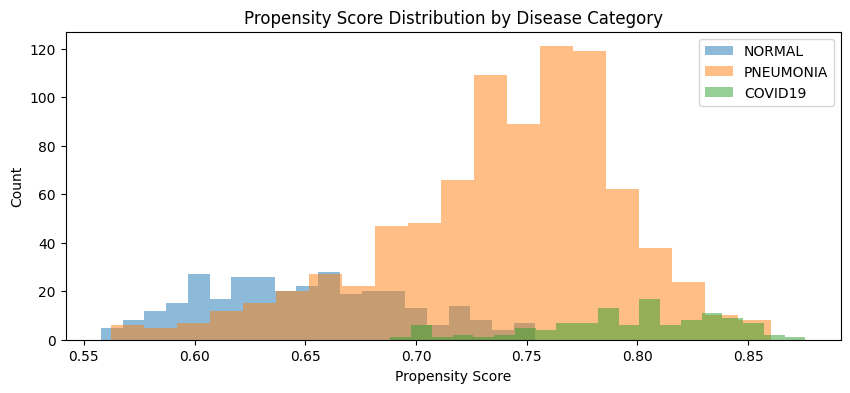

In [13]:
# Implementation
prop_model = PropensityNet(rep_dim=256).to(device)
print("\n===== Training Propensity Model =====")
prop_losses = train_propensity(prop_model, train_loader, num_epochs=20, lr=1e-3)
print("\n===== Evaluating Propensity Model =====")
p_hat_test, t_test = evaluate_propensity(prop_model, test_loader)

plt.figure(figsize=(10, 4))
for cat in ['NORMAL', 'PNEUMONIA', 'COVID19']:
    mask = np.array([test_dataset.categories[i] == cat for i in range(len(test_dataset))])
    plt.hist(p_hat_test[mask], alpha=0.5, label=cat, bins=20)
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Propensity Score Distribution by Disease Category')
plt.show()